Import statements

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import dill

Reading the Version 1.1 of the dataset

The Serial No. can be set as the index as it does not have any other purpose

Renaming the columns which had extra white spaces

In [2]:
data = pd.read_csv('../input/Admission_Predict_Ver1.1.csv').set_index('Serial No.')
data = data.rename(columns={'Chance of Admit ': 'Chance of Admit', 'LOR ': 'LOR'})

In [3]:
print('The dataset has {} rows.'.format(len(data)))
print('The dataset has {} columns'.format(data.columns))

The dataset has 500 rows.
The dataset has Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance of Admit'],
      dtype='object') columns


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1 to 500
Data columns (total 8 columns):
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB
None


In [5]:
print(data.isnull().any())

GRE Score            False
TOEFL Score          False
University Rating    False
SOP                  False
LOR                  False
CGPA                 False
Research             False
Chance of Admit      False
dtype: bool


None of the values have any Null values

Checking the correlation between all the features

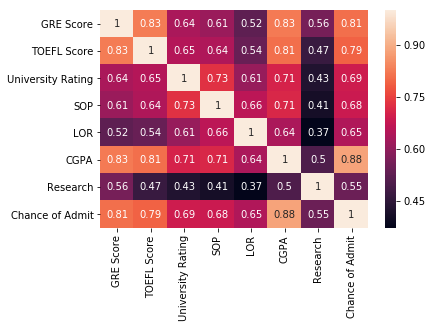

In [6]:
sns.heatmap(data.corr(), annot=True)

The Chance of Admit strongly correlates with CGPA, GRE Score and TOEFL Score. It has a weaker correlation with University Rating, SOP and LOR. The Research has the least correlation.

Let us look at individual features and their properties

The Research feature is a binary value and will not show any significant results in the PairPlot. It can be dropped

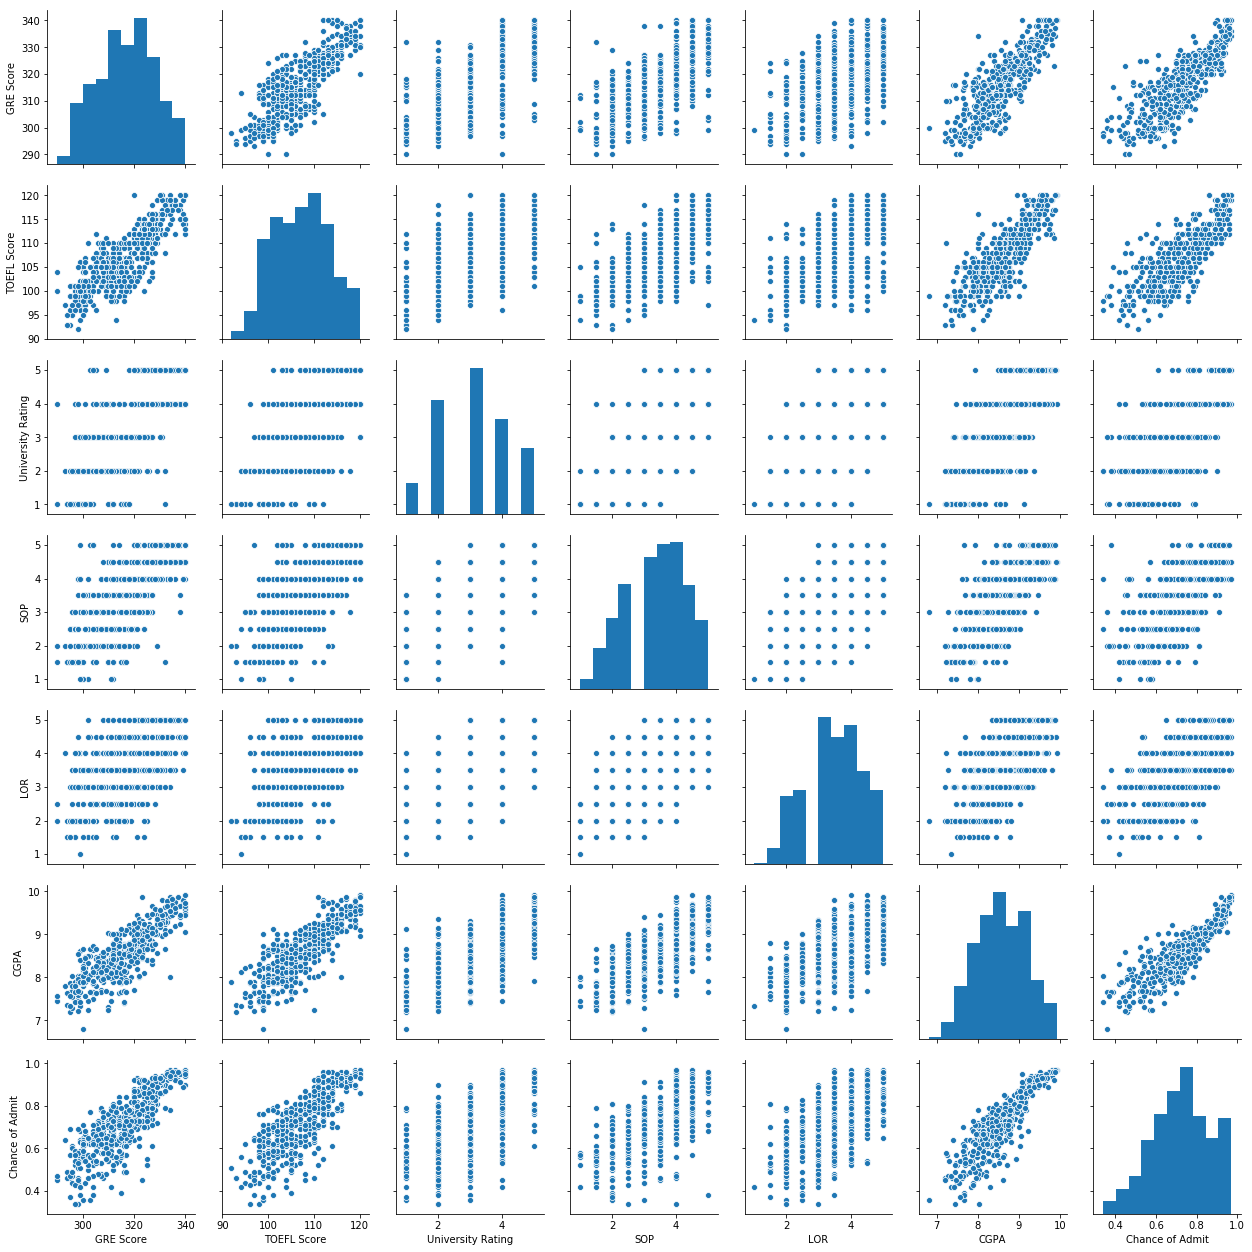

In [7]:
sns.pairplot(data.drop(columns='Research'))

The PairPlot gives a lot of information in one plot. Let us disect it by each feature.
    1. As GRE Score increases, the TOEFL Scores also increases and even the CGPA Score increases. This means that students who score good GRE Scores also score good TOEFL Scores and have better CGPAs.
    2. GRE Score has a distribution with a mean near 320 and majority of students score between 310 to 330 which is indicated by the peaks in the graph.
    3. Students from higher University Rating have higher GRE Scores, TOEFL Scores and CGPA.
    4. Students have better LOR and SOP rating when they are from higher rated universities.
    5. We can see a similar trend for relation between GRE Scores, TOEFL Scores, CGPA Scores, LOR Ratings and SOP Ratings. They all increases together, i.e., as students with better SOPs also tend to have better LORs, better GRE, TOEFL and CGPA Scores and are from higher rated universities and they have a higher chance of admit.

Splitting the data into training and testing set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='Chance of Admit'), data['Chance of Admit'], test_size=0.2)

In [9]:
X_train.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.300000,107.005000,3.085000,3.340000,3.456250,8.566300,0.550000
std,11.421082,6.193211,1.155905,1.023239,0.923766,0.611891,0.498117
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000
25%,308.000000,102.000000,2.000000,2.500000,3.000000,8.120000,0.000000
50%,316.000000,106.500000,3.000000,3.500000,3.500000,8.555000,1.000000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.025000,1.000000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000


The ranges of all the features are very distinct and should be scaled correctly before making any predictions

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


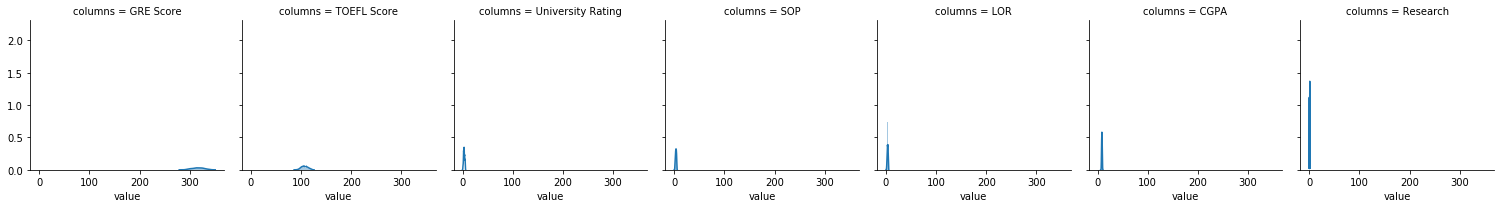

In [10]:
dfm = X_train.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

In [11]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


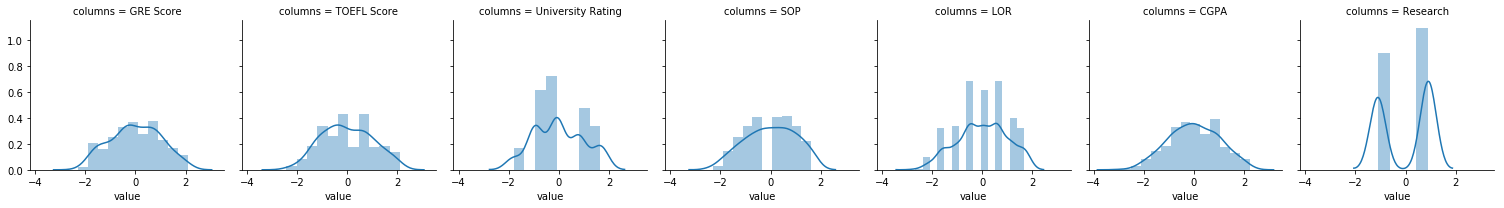

In [12]:
dfm = X_train.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

We can see that all the values have 0 mean and have a normal distribution. This enables the model to make better predictions.

Creating a Grid Search for Random Forest Regressor

In [13]:
gridsearch = GridSearchCV(estimator=RandomForestRegressor(),
                          param_grid={
                              'n_estimators': [50, 100, 250, 300],
                              'max_depth': [None, 100, 200, 300, 400]
                          },
                          cv=3,
                          return_train_score=False,
                          scoring='r2')
gridsearch.fit(X=X_train, y=y_train)
pd.DataFrame(gridsearch.cv_results_).set_index('rank_test_score').sort_index()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,
1,0.267136,0.003994,0.015769,0.000567,200,250,"{'max_depth': 200, 'n_estimators': 250}",0.798277,0.736457,0.780922,0.771951,0.026035
2,0.105804,0.001278,0.007208,0.000136,200,100,"{'max_depth': 200, 'n_estimators': 100}",0.797948,0.737435,0.777618,0.771068,0.025148
3,0.054869,0.000793,0.004488,0.000008,100,50,"{'max_depth': 100, 'n_estimators': 50}",0.793705,0.733951,0.784816,0.770881,0.026317
4,0.319648,0.001558,0.018576,0.000253,300,300,"{'max_depth': 300, 'n_estimators': 300}",0.794885,0.731172,0.784285,0.770176,0.027867
5,0.264513,0.002652,0.015413,0.000528,300,250,"{'max_depth': 300, 'n_estimators': 250}",0.796904,0.729838,0.783151,0.770032,0.028919
6,0.316172,0.002706,0.017965,0.000237,100,300,"{'max_depth': 100, 'n_estimators': 300}",0.794828,0.731940,0.783047,0.770001,0.027290
7,0.264266,0.002562,0.015531,0.000348,100,250,"{'max_depth': 100, 'n_estimators': 250}",0.797356,0.729542,0.782563,0.769889,0.029111
8,0.320830,0.003916,0.018021,0.000243,None,300,"{'max_depth': None, 'n_estimators': 300}",0.796396,0.733780,0.777895,0.769425,0.026268
9,0.266628,0.003126,0.015375,0.000068,None,250,"{'max_depth': None, 'n_estimators': 250}",0.796940,0.728520,0.781557,0.769076,0.029305


Taking a look at the Grid Search results, we can see that the Random Forest Regressor with a maximum depth of 200 and 300 estimators gave the best results. But, when we look more closely, we can see that the regressor with maximum depth as None and number of estimators as 50 give almost the same result (difference is 0.001465) but takes less than half the time to make the predictions. If time is of concern, this model should be picked.

Because Random Forest is "random", the results and the inference above might change when this Notebook is run when making the commit.

Creating a pipeline

In [14]:
pipe = make_pipeline(scaler, gridsearch)

This pipeline can be used to deploy this model. It contains the complete model which scales the input data and runs it through the Random Forest to get a prediction.

Testing out the predictions of the pipeline and the model trained above.

In [15]:
print('Original model: ' + str(gridsearch.predict(X=scaler.transform(data.drop(columns='Chance of Admit').iloc[0].values.reshape(1, -1)))[0]))
print('Pipeline model: ' + str(pipe.predict(X=data.drop(columns='Chance of Admit').iloc[0].values.reshape(1, -1))[0]))

Original model: 0.9400799999999978
Pipeline model: 0.9400799999999978


The predictions are the same. We can now export the pipeline.

In [16]:
with open('rf_v1.pkl', 'wb') as f:
    dill.dump(pipe, f)

In [17]:
with open('rf_v1.pkl', 'rb') as f:
    model = dill.load(f)
    print(model.predict(X=data.drop(columns='Chance of Admit').iloc[0].values.reshape(1, -1))[0])

0.9400799999999978


We can see that the model is exported correctly and when imported, gives the same prediction for the same data.